## Loading useful libraries and modules

In [1]:
import os
import random
import shutil

import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

random.seed(0)
np.random.seed(0)
torch.manual_seed(0);

## Preparing the training and test sets

In [5]:
path = {
    'root' : './appliances/',
    'train': './appliances/train',
    'test' : './appliances/test',   
}

In [2]:
if os.path.isdir(path['root']):

    try:

        os.mkdir(os.path.join(path['root'], 'train'))
        os.mkdir(os.path.join(path['root'], 'test'))

        labels = ['fogao', 'fritadeira', 'geladeira', 'lavadora', 'microondas', 'tv', 'ventilador']

        for label in tqdm(labels):

            os.mkdir(os.path.join(path['root'], 'train', label))
            os.mkdir(os.path.join(path['root'], 'test', label))

            img_names = [img_name for img_name in os.listdir(os.path.join(path['root'], label)) 
                            if os.path.splitext(img_name)[-1] == '.jpg']

            np.random.shuffle(img_names)
            split_indices = int(len(img_names) * 0.8)

            train_images = img_names[:split_indices] # 80% from data for training
            valid_images = img_names[split_indices:] # 20% from data for validation

            for img_name in train_images:
                scr = os.path.join(path['root'], label, img_name)
                dst = os.path.join(path['root'], 'train', label, img_name)
                shutil.copy(scr, dst)

            print('label:', label, 'taining samples:', len(train_images))

            for img_name in valid_images:
                scr = os.path.join(path['root'], label, img_name)
                dst = os.path.join(path['root'], 'test', label, img_name)
                shutil.copy(scr, dst)

            print('label:', label, 'test samples:', len(valid_images))
            print('---')

    except FileExistsError as e:
        print(e)

label: fogao taining samples: 2616
label: fogao test samples: 654
---
label: fritadeira taining samples: 776
label: fritadeira test samples: 195
---
label: geladeira taining samples: 1284
label: geladeira test samples: 321
---
label: lavadora taining samples: 868
label: lavadora test samples: 218
---
label: microondas taining samples: 373
label: microondas test samples: 94
---
label: tv taining samples: 909
label: tv test samples: 228
---
label: ventilador taining samples: 3560
label: ventilador test samples: 890
---



## Defining the hyperparameters

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

args = {
    'device'        : device,
    'batch_size'    :     64,
    'num_workers'   :      4,
    'learning_rate' :   1e-2,
    'epochs'        :     30,
    'mode'          :  'max', 
    'patience'      :      3,
    }

## Defining the transformations and loading the data

In [7]:

normalize = transforms.Normalize((0.485, 0.456, 0.406),
                                 (0.229, 0.224, 0.225))

TRANSFORM = {
    'train' : transforms.Compose([
              transforms.RandomResizedCrop((224, 224)),     
              transforms.ToTensor(),
              normalize,
              ]),
    'test'  : transforms.Compose([transforms.Resize((256, 256)),
                                  transforms.CenterCrop(224),
                                  transforms.ToTensor(),
                                  normalize])
}

In [8]:
train_set = torchvision.datasets.ImageFolder(root=path['train'], transform=TRANSFORM['train'])
test_set  = torchvision.datasets.ImageFolder(root=path['test'], transform=TRANSFORM['test'])

print(f'The training set has {len(train_set)} samples')
print(f'The test set has {len(test_set)} samples')

The training set has 10386 samples
The test set has 2600 samples


## Visualizing the data distribution

In [6]:
train_images_per_class = {}

for class_name in train_set.classes:
    img_path  = os.path.join(path['train'], class_name)
    img_names = [img_name for img_name in os.listdir(img_path)
                 if os.path.splitext(img_name)[-1] == '.jpg']

    train_images_per_class[class_name] = len(img_names)

valid_images_per_class = {}

for class_name in test_set.classes:
    img_path  = os.path.join(path['test'], class_name)
    img_names = [img_name for img_name in os.listdir(img_path)
                 if os.path.splitext(img_name)[-1] == '.jpg']

    valid_images_per_class[class_name] = len(img_names)

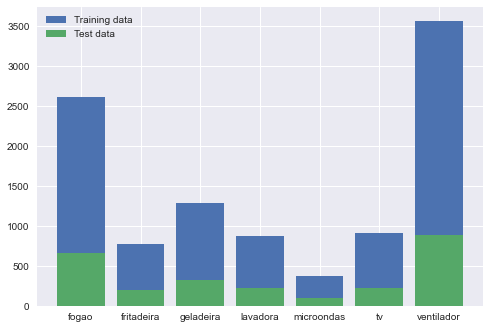

In [7]:
plt.style.use('seaborn')
plt.bar(*zip(*train_images_per_class.items()), label='Training data')
plt.bar(*zip(*valid_images_per_class.items()), label='Test data')
plt.legend(loc='best')
# plt.tight_layout()
plt.show()

In [8]:
print(f'Total of images: {pd.Series(train_images_per_class).sum()}', '---', sep='\n')
(pd.Series(train_images_per_class).mul(100) / pd.Series(train_images_per_class).sum()).round(2)

Total of images: 10386
---


fogao         25.19
fritadeira     7.47
geladeira     12.36
lavadora       8.36
microondas     3.59
tv             8.75
ventilador    34.28
dtype: float64

## Preparing the validation set

In [9]:
np.random.seed(0)

# Percentage of training set to use as validation
valid_size = 0.2

# Obtain training indices that will be used for validation
num_train = len(train_set)
indices   = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_index, valid_index = indices[split:], indices[:split]

# Define samples for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_index)
valid_sampler = SubsetRandomSampler(valid_index)

In [10]:
train_loader = torch.utils.data.DataLoader(train_set, args['batch_size'], sampler=train_sampler, num_workers=args['num_workers'], pin_memory=True)
valid_loader = torch.utils.data.DataLoader(train_set, args['batch_size'], sampler=valid_sampler, num_workers=args['num_workers'], pin_memory=True)
test_loader  = torch.utils.data.DataLoader(test_set, args['batch_size'], shuffle=True, num_workers=args['num_workers'], pin_memory=True)

## Visualizing a simple batch from training set

In [11]:
images, labels = next(iter(train_loader))
images.size(), labels.size()

(torch.Size([64, 3, 224, 224]), torch.Size([64]))

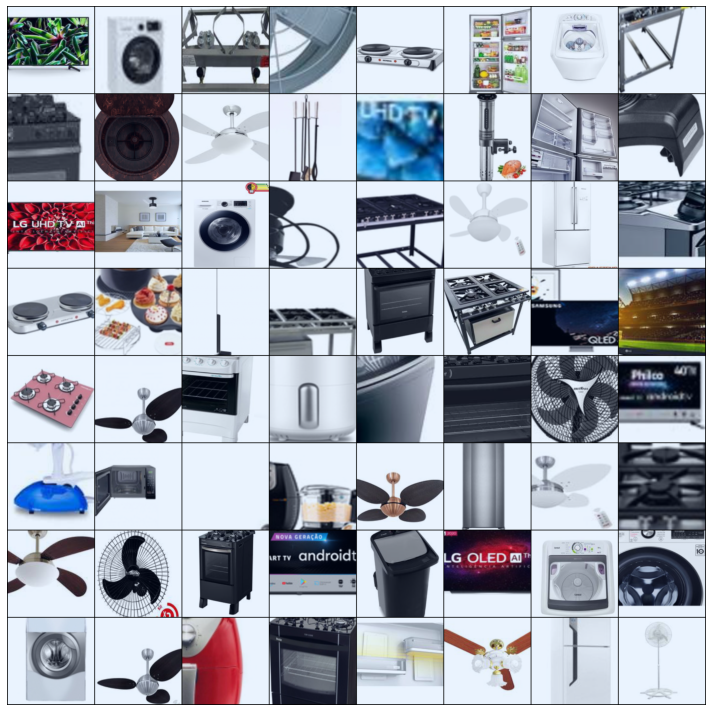

In [25]:
grid = torchvision.utils.make_grid(images, nrow=8, normalize=True)
plt.figure(figsize=(10, 10))
plt.imshow(grid.permute(1, 2, 0))
plt.axis('off')
plt.tight_layout()
plt.show()

## Training and validating the model

In [27]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg16 = models.vgg16(pretrained=True)

        # Freeze
        for param in self.vgg16.parameters():
            param.requires_grad = False

        self.vgg16.classifier[-1] = nn.Linear(in_features=4096, out_features=7)        

    def forward(self, x):        
        x = self.vgg16(x)
        
        return x

In [29]:
classifier = Classifier().to(args['device'])
criterion  = nn.CrossEntropyLoss()
optimizer  = optim.Adam(classifier.parameters(), lr=args['learning_rate'])
scheduler  = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode=args['mode'], patience=args['patience'], verbose=True)

In [15]:
%%time

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf

history = {
    'train_loss': [],
    'train_acc' : [],
    'valid_loss': [],
    'valid_acc' : [],
    }

for epoch in range(args['epochs']):

    train_loss = 0
    train_acc  = 0

    # Set train mode
    classifier.train()

    for images, labels in train_loader:

        images = images.to(args['device'])
        labels = labels.to(args['device'])

        # Clear gradientss
        optimizer.zero_grad()

        # Forward pass
        outputs  = classifier(images)
        loss     = criterion(outputs, labels)
        _, preds = torch.max(outputs, dim=1)

        # Backward
        loss.backward() 
        optimizer.step()

        train_loss += loss.item()
        # train_acc  += (preds == labels).sum().item()
        train_acc  += torch.mean((preds == labels).to(dtype=torch.float)).item()

        
    else:
        
        valid_loss = 0
        valid_acc  = 0

        # Turn off the gradients for the validation pass
        with torch.no_grad():            
    
            # Set model to evalutaion mode 
            classifier.eval()
    
            for images, labels in valid_loader:
    
                images = images.to(args['device'])
                labels = labels.to(args['device'])
    
                # Forward pass
                outputs  = classifier(images)
                loss     = criterion(outputs, labels)
                _, preds = torch.max(outputs, dim=1)
    
                valid_loss += loss.item()
                valid_acc  += torch.mean((preds == labels).to(dtype=torch.float)).item()
    
            # Compute metrics
            train_loss /= len(train_loader)
            train_acc  /= len(train_loader)
            valid_loss /= len(valid_loader)
            valid_acc  /= len(valid_loader)
     
            # Leaning rate will dacay if validation accuracy did not improve after three epochs.
            scheduler.step(metrics=valid_acc)
    
        print(f'Epoch {epoch + 1}/{args["epochs"]} - train_loss: {train_loss:7.6f} - train_acc: {train_acc:.2%} -', 
              f'valid_loss: {valid_loss:7.6f} - valid_acc: {valid_acc:.2%}')

        # Save model if the validation loss has decreased
        if valid_loss <= valid_loss_min:
            print(f'Validation loss decreased {valid_loss_min:.6f} --> {valid_loss:.6f}. Saving model...\n')
            torch.save(classifier.state_dict(), 'appliance.pth')
            valid_loss_min = valid_loss
    
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['valid_loss'].append(valid_loss)
        history['valid_acc'].append(valid_acc)

Epoch 1/30 - train_loss: 0.846627 - train_acc: 85.75% - valid_loss: 0.557375 - valid_acc: 89.60%
Validation loss decreased inf --> 0.557375. Saving model...

Epoch 2/30 - train_loss: 0.791273 - train_acc: 88.29% - valid_loss: 0.571305 - valid_acc: 91.27%
Epoch 3/30 - train_loss: 0.940774 - train_acc: 88.26% - valid_loss: 0.652489 - valid_acc: 92.31%
Epoch 4/30 - train_loss: 0.981491 - train_acc: 89.29% - valid_loss: 0.597660 - valid_acc: 92.25%
Epoch 5/30 - train_loss: 0.960807 - train_acc: 89.77% - valid_loss: 0.604384 - valid_acc: 92.27%
Epoch 6/30 - train_loss: 1.025785 - train_acc: 89.74% - valid_loss: 0.548650 - valid_acc: 92.70%
Validation loss decreased 0.557375 --> 0.548650. Saving model...

Epoch 7/30 - train_loss: 0.984526 - train_acc: 89.73% - valid_loss: 0.671768 - valid_acc: 93.04%
Epoch 8/30 - train_loss: 1.061607 - train_acc: 89.57% - valid_loss: 0.868156 - valid_acc: 91.15%
Epoch 9/30 - train_loss: 1.048352 - train_acc: 90.09% - valid_loss: 0.766226 - valid_acc: 93.28%


In [16]:
hist = pd.DataFrame(history)
hist.head()

,train_loss,train_acc,valid_loss,valid_acc
0,0.846627,0.857543,0.557375,0.896013
1,0.791273,0.882928,0.571305,0.912683
2,0.940774,0.882568,0.652489,0.923100
3,0.981491,0.892904,0.597660,0.922528
4,0.960807,0.897712,0.604384,0.922724


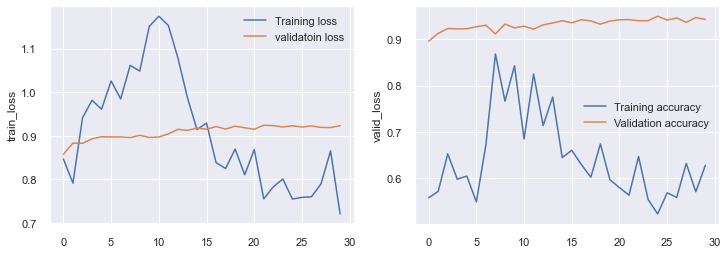

In [17]:
sns.set()
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(x=hist.index, y='train_loss', data=hist, label='Training loss', ax=ax[0])
sns.lineplot(x=hist.index, y='train_acc', data=hist, label='validatoin loss', ax=ax[0])
sns.lineplot(x=hist.index, y='valid_loss', data=hist, label='Training accuracy', ax=ax[1])
sns.lineplot(x=hist.index, y='valid_acc', data=hist, label='Validation accuracy', ax=ax[1]);

## Evaluating the model


In [30]:
# Loading the best model
classifier.load_state_dict(torch.load('./appliance.pth'));

In [19]:
with torch.no_grad():

    test_acc = 0
    
    # Set model to evalutaion mode
    classifier.eval()

    for images, labels in test_loader:
        images = images.to(args['device'])
        labels = labels.to(args['device'])
    
        # Forward pass
        outputs  = classifier(images)
        # loss     = criterion(outputs, labels)
        _, preds = torch.max(outputs, dim=1)
    
        # valid_loss += loss.item()
        test_acc += torch.mean((preds == labels).to(dtype=torch.float)).item()

    test_acc /= len(test_loader)

print(f'Test accuracy: {test_acc:2%}')

Test accuracy: 97.042683%


## Visualizing sample test results

In [31]:
def show_images(images, labels, preds):

    classes = test_set.classes

    fig, axes = plt.subplots(nrows=2, ncols=8, figsize=(14, 5),
                             subplot_kw={'xticks': [], 'yticks': []}) 


    for i, (ax, img) in enumerate(zip(axes.flat, images)):
        
        img  = img.permute(1, 2, 0)
        img  = img.data.cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406])
        std  = np.array([0.229, 0.224, 0.225])
        img  = (img * std) + mean
        img  = np.clip(img, 0, 1)
        
        ax.imshow(img)
        
        # Label
        ax.set_title(f'{classes[labels[i]]}', size='x-large') 
        
        # Predictions
        color = 'green' if preds[i] == labels[i] else 'red'
        ax.set_xlabel(f'{classes[preds[i]]}', color=color, size='x-large')           
    
    plt.tight_layout()
    plt.show()


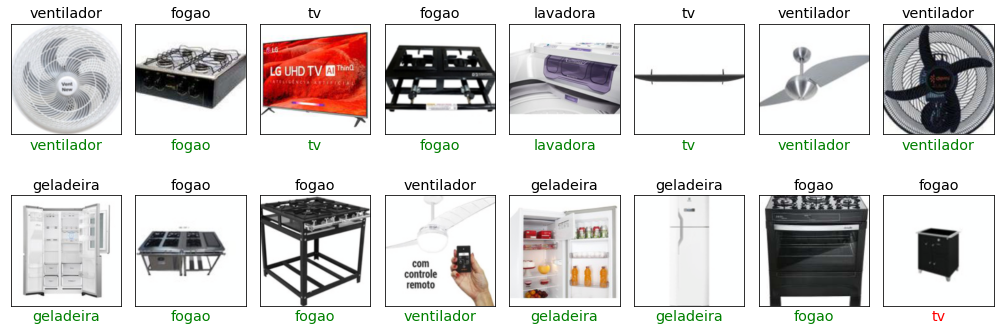

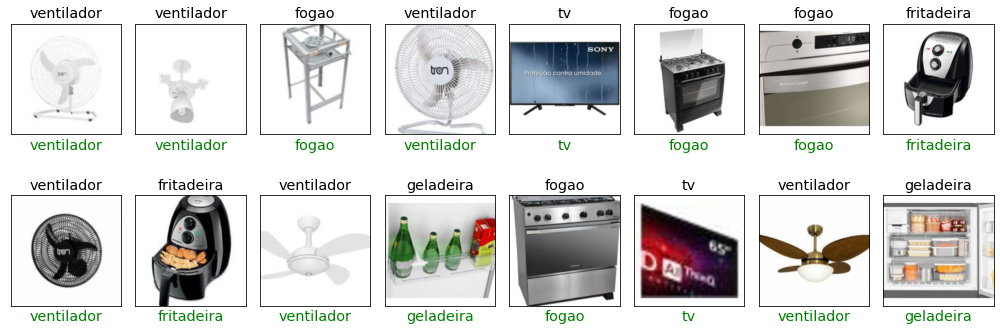

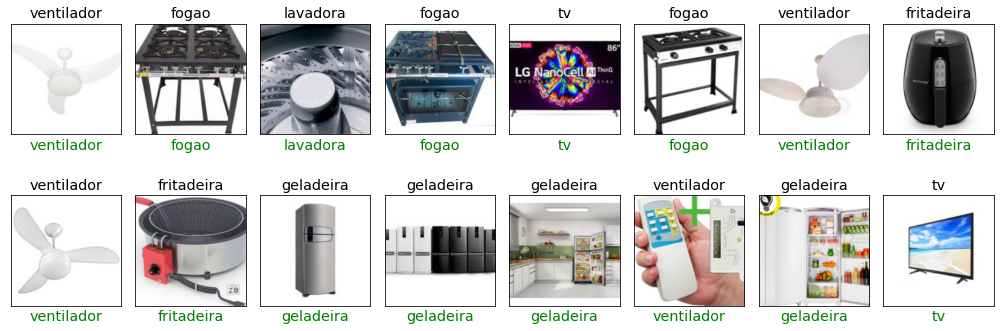

In [32]:
with torch.no_grad():
    
    classifier.eval()

    for _ in range(3):
        batch  = next(iter(test_loader))
        images = batch[0].to(args['device'])
        labels = batch[1].to(args['device'])
       
        outputs  = classifier(images)
        _, preds = torch.max(outputs, 1)
       
        show_images(images, labels, preds)